# Diyabet Tahmin Modeli

### Veri Seti Hikayesi : 

- Veri seti Ulusal Diyabet ve Sindirim ve Böbrek Hastalıkları Enstitüsü'nden alınmıştır.

- Amaç, belirli tanı ölçümlerine dayanarak bir hastanın diyabet olup olmadığını teşhis eden model oluşturmak.

- Bu örnekler, daha büyük bir veritabınından çeşitli kısıtlamalar ile seçilmiştir.

- Veri setindeki tüm hastalar en az 21 yaşında olan pima indian soyundan kadınlardır.

### Değişkenler :

- **Pregnancies:** Hamilelik sayısı

- **Glucose:** Oral glikoz tolerans testintinde 2 saatlik plazma glikoz konsantrasyonu

- **BloodPressure:** Kan basıncı (Küçük tansiyon) (mm Hg)

- **SkinThickness:** Cilt kalınlığı

- **Insulin:** 2 saatlik serum insülini (mu U/ml)

- **BMIBody:** Vücut kitle indeksi (Weight in kg/(height in m)^2)

- **DiabetesPedigreeFunction:** Aile geçmişine göre diyabet olasılığını puanlayan bir fonksyion.

- **Age:** Yaş (yıl)

- **Outcome:** Hastalığa sahip (1) ya da değil (0)

### NOT

- HEDEF 0.7760
- Tüm modelleri değil 3 tane model ile ilerleyiniz.
- Tüm veri kullanılarak cv hatasına bakılacak. Random state: 123456
- Başarı nasıl artırılır? veri ön işleme, literatür, yeni değişken türetme, hiperparametre optimizasyonu

In [276]:
#Gerekli Kütüphanelerin Yüklenmesi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, \
    classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.simplefilter(action="ignore")

pd.pandas.set_option('display.max_columns', None)
pd.pandas.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [277]:
# Veri setinin okutulması
df = pd.read_csv("diabetes.csv")

## EDA

In [278]:
# ilk 5 gözlem
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [279]:
# Gözlem ve değişken sayısı
df.shape

(768, 9)

In [280]:
print("Veri setinde mevcut satır sayısı {0} ve sutun sayısı {1} . ".format(df.shape[0],df.shape[1]))

Veri setinde mevcut satır sayısı 768 ve sutun sayısı 9 . 


Gözlem sayısı az. Hold-out yöntemiyle 75-25, 80-20 bölündüğünde veri kaybı olacaktır. Bu nedenle modelleme için ve model başarısını değerlendirmek için K-fold Cross Validation (k katlı çapraz doğrulama) yöntemi kullanılacak.

In [281]:
# değişkenlerin isimleri
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [282]:
# info() metoduyla sutunlardaki toplam dolu değer adetini, sutunların veri tiplerinin ne olduğuna ve toplamda hafızada ne kadar değer tuttuğuna bakalım.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [283]:
# null değer var mı?
df.isnull().values.any()

False

In [284]:
# Bağımlı değişkenin sınıflarının oranı
df["Outcome"].value_counts()*100 / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

In [285]:
# Sayısal değişkenlerin tanımlayıcı istatistikleri
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


**Not:** Minimum değeri 0 olamayacak değişkenler var. Bu nedenle bazı değişkenlerde 0 değeri null değer olarak kabul edilebilir.

## Kategorik Değişken Analizi

In [286]:
# Kaç Kategorik değişken var?

In [287]:
# birinci yol klasik for ve if döngüsü
cat_colsF = []
for col in df.columns:
    if len(df[col].unique()) < 10:
        cat_colsF.append(col)
cat_colsF

['Outcome']

In [288]:
# List comprehension yöntemi 
cat_cols = [col for col in df.columns if len(df[col].unique()) < 10]
print(cat_cols)

['Outcome']


In [289]:
# Kaç adet sınıfa sahip?

In [290]:
# nunique() fonksiyonu ise bize bir sutunda kaç farklı eşsiz veri olduğunu vermekte
df["Outcome"].nunique()

2

In [291]:
# unique() fonksiyonu bize bir sutundaki eşsiz verileri vermekte
df["Outcome"].unique()

array([1, 0])

In [292]:
# Outcome Sutundaki her bir eşsiz değerden kaç adet var onu arıyoruz
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

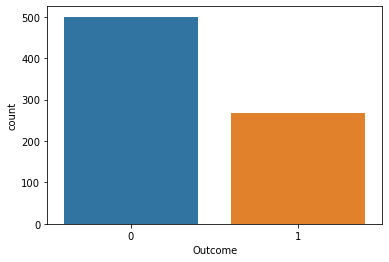

In [293]:
# grafik ile görselleştirme
sns.countplot(x="Outcome", data=df);

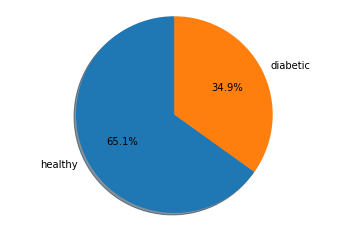

In [294]:
# grafik ile görselleştirme
fig1, ax1 = plt.subplots()
ax1.pie(df["Outcome"].value_counts(),  labels=['healthy','diabetic'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

## Sayısal Değişken Analizi

In [295]:
# Sayısal değişkenlerin sayısı
num_cols = [col for col in df.columns if df[col].dtypes != "O" and col not in "Outcome"] # target değişkeni değil ve tipi onject değil ise
print('Sayısal Değişkenlerin Sayısı: ', len(num_cols))

Sayısal Değişkenlerin Sayısı:  8


In [296]:
#Sayısal değişkenlerin isimleri
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [297]:
# Outcome değişkeninin sınıflarına göre sayısal değişkenlerin ortalama ve medyanlarının incelenmesi
# Fonksiyon sayısal değişkenleri bulup, bu sayısal değişkenlerin target değişkeninin sınıflarına göre ortalama ve medyanını gösteriyor
def target_summary_with_nums(dataframe,target):
    num_names=[col for col in dataframe.columns if df[col].dtype!="O"
               and col not in target]                            
    for var in num_names:
        print(df.groupby(target).agg({var: ["mean","median"]}), end ="\n\n\n")


target_summary_with_nums(df,"Outcome")

        Pregnancies       
               mean median
Outcome                   
0             3.298      2
1             4.866      4


        Glucose       
           mean median
Outcome               
0       109.980    107
1       141.257    140


        BloodPressure       
                 mean median
Outcome                     
0              68.184     70
1              70.825     74


        SkinThickness       
                 mean median
Outcome                     
0              19.664     21
1              22.164     27


        Insulin       
           mean median
Outcome               
0        68.792     39
1       100.336      0


           BMI       
          mean median
Outcome              
0       30.304 30.050
1       35.143 34.250


        DiabetesPedigreeFunction       
                            mean median
Outcome                                
0                          0.430  0.336
1                          0.550  0.449


           Age       

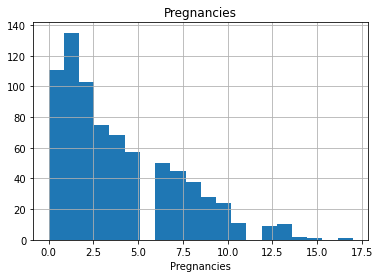

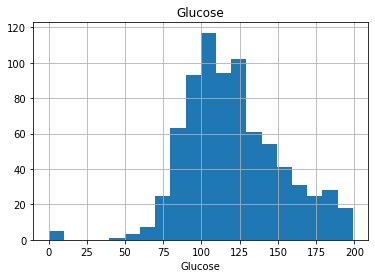

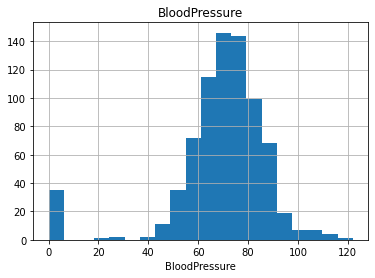

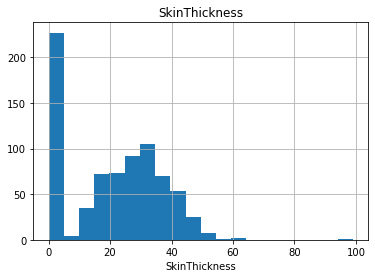

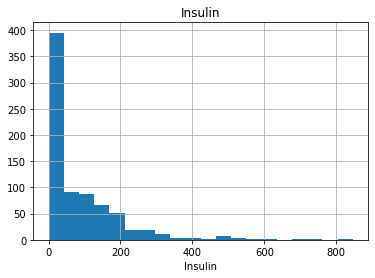

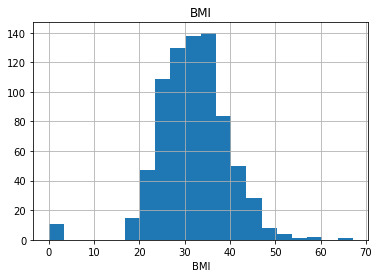

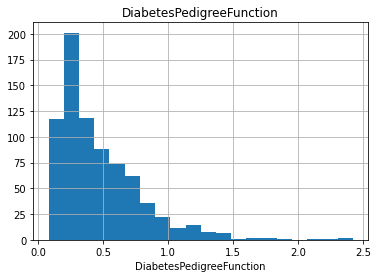

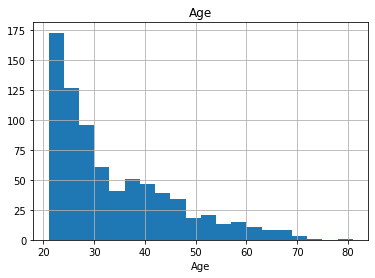

8 variables have been plotted


In [298]:
# Sayısal değişkenlerin görselleştirilmesi
def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].hist(bins=20)
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")

hist_for_nums(df, num_cols)

## Correlation Matrix

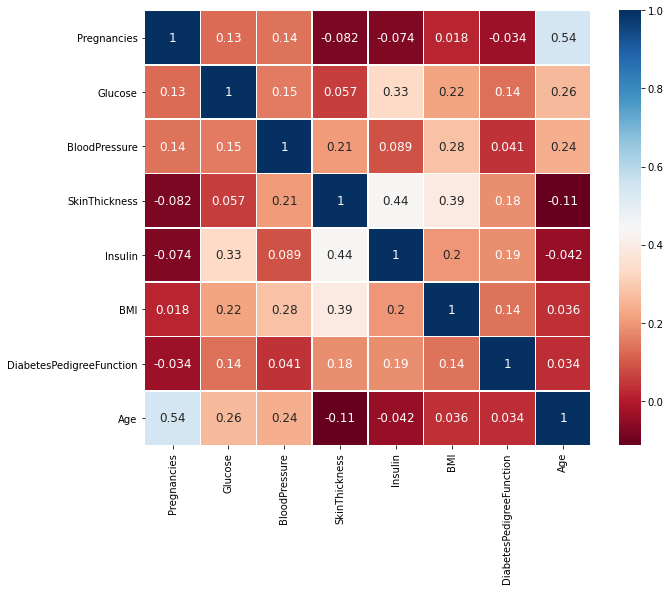

In [299]:
# değişkenler arasındaki ilişki gözlemleyelim
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w',cmap='RdBu')
    plt.show()

correlation_matrix(df, num_cols)

##  DATA PREPROCESSING 

### 1. Eksik Değer Analizi

In [300]:
# Değişkenlerdeki eksik değer sayısı
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Veri setinde ki bazı değişkenlerin minimum değerlerinin sıfır olduğunu görmüştük. Hamilelik değişkeni hariç Glikoz, Kan Basıncı, 
Cilt Kalınlığı, İnsülin ve BMI değişkenleri yaşayan bir kişide sıfır olamaz.
Bu nedenle bu değişkenler için 0 değerini NaN kabul edebiliriz.
0 değerlerini NaN olarak değiştirebiliriz, eksik değerleri tekrar gözlemleyelim.

In [301]:
# 0 değerlerinin NaN olarak değiştirilmesi Glucose, Blood Pressure, Skin Thickness, Insulin, BMI değişkenleri için
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    df[col].replace(0,np.NaN,inplace=True)

In [302]:
#Tekrar Nan değer sayısını kontrol edelim
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [303]:
# Artık değişkenlerdeki eksik değerleri gözlemleyip, doldurabiliriz.

In [304]:
# NaN değerleri Outcome değişkenine göre medyan ile dolduralım
# for döngüsü ile bütün değişkenleri gezelim
for col in df.columns:
    # Eğer değişkendeki değerler boş ve Outcomeları 0 ise  değişkenin Outcome'ı 0 olan değerlerinin medyanını boş değerlere ata
    df.loc[(df["Outcome"]==0) & (df[col].isnull()),col] = df[df["Outcome"]==0][col].median() 
    # Eğer değişkendeki değerler boş ve Outcomeları 1 ise  değişkenin Outcome'ı 1 olan değerlerinin medyanını boş değerlere ata
    df.loc[(df["Outcome"]==1) & (df[col].isnull()),col] = df[df["Outcome"]==1][col].median()

In [305]:
# Boş değer kaldı mı?
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### 2. Aykırı Değer Analizi

In [306]:
# Aykırı değerler için alt ve üst eşik belirleyen fonksiyon
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [307]:
# Değişkenlerde aykırı değer var mı yok mu gösteren fonksiyon
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable, "yes")

In [308]:
# Hangi değişkenlerde aykırı değerler var?
for col in df.columns:
    has_outliers(df, col)

SkinThickness yes
Insulin yes
DiabetesPedigreeFunction yes


In [309]:
# #Aykırı değerleri gözlemlemek için bu 3 değişkeni görselleştirelim

<AxesSubplot:xlabel='Insulin'>

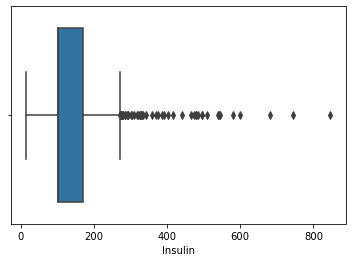

In [310]:
sns.boxplot(x = df["Insulin"])

<AxesSubplot:xlabel='SkinThickness'>

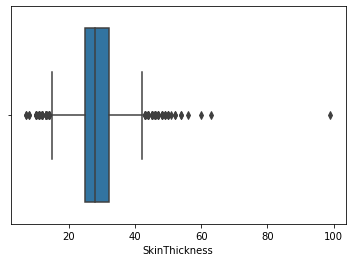

In [311]:
sns.boxplot(x = df["SkinThickness"])

<AxesSubplot:xlabel='DiabetesPedigreeFunction'>

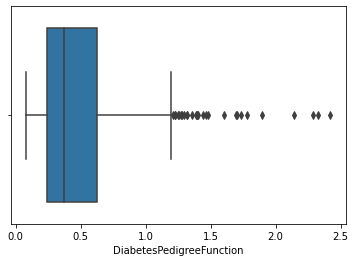

In [312]:
sns.boxplot(x = df["DiabetesPedigreeFunction"])

In [313]:
# Aykırı değerler yerine eşik değerlerini koyup, baskılama yöntemi
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [314]:
replace_with_thresholds(df, df.columns)

In [315]:
# Aykırı değer kaldı mı? Hayır
for col in df.columns:
    has_outliers(df, col)

## Feature Engineering

In [316]:
# Normal -> İki saatlik glikoz seviyesi 140 mg / dL'den az ise
# Prediabetes(gizli şeker) -> İki saatlik glikoz seviyesi 140 ila 200 mg / dL arasında ise
df['New_Glucose_Class'] = pd.cut(x=df['Glucose'], bins=[0,139,200],labels = ["Normal","Prediabetes"])

In [317]:
# Yaşa göre Young, middle age ve old larak 3 sınıftan oluşan yeni değişken 
df.loc[(df['Age'] < 30), "NEW_Age_CAT"] = 'Young'
df.loc[(df['Age'] >=30) & (df['Age'] <= 45), "NEW_Age_CAT"] = 'Middleage'
df.loc[(df['Age'] > 45) , "NEW_Age_CAT"] = 'Old'

In [318]:
# Vücut Kitle indeksine göre kategorileme
# 0-18.5 -> Underweight
# 18.5-24.9 -> Healty
# 24.9-29.9 -> Overweight
# 29.9-100 -> Obese
df['New_BMI_Range'] = pd.cut(x=df['BMI'], bins=[0,18.5,24.9,29.9,100],labels = ["Underweight","Healty","Overweight","Obese"])

In [319]:
# Kan basıncı (küçük tansiyonu ifade ediyor değişken)
# 0 - 79 arasında Normal
# 79 - 89 arasında HS1 (Hipertansiyon 1)
# 89 - 123 arasında HS2 (Hipertansiyon 2)
df['New_BloodPressure'] = pd.cut(x=df['BloodPressure'], bins=[0,79,89,123],labels = ["Normal","HS1","HS2"])

In [320]:
# insulin değeri 16 ile 166 arasında ise Normal değilse Abnormal
df['New_Insulin'] = df['Insulin'].apply(lambda x: "Normal" if x >= 16.0 and x<=166 else "Abnormal")

In [321]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Glucose_Class,NEW_Age_CAT,New_BMI_Range,New_BloodPressure,New_Insulin
0,6.000,148.000,72.000,35.000,169.500,33.600,0.627,50.000,1.000,Prediabetes,Old,Obese,Normal,Abnormal
1,1.000,85.000,66.000,29.000,102.500,26.600,0.351,31.000,0.000,Normal,Middleage,Overweight,Normal,Normal
2,8.000,183.000,64.000,32.000,169.500,23.300,0.672,32.000,1.000,Prediabetes,Middleage,Healty,Normal,Abnormal
3,1.000,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0.000,Normal,Young,Overweight,Normal,Normal
4,0.000,137.000,40.000,35.000,168.000,43.100,1.949,33.000,1.000,Normal,Middleage,Obese,Normal,Abnormal


## Encoding

In [322]:
# kategorik değişkenlere one hot encoding uygulanması
# yeni dataframe'i ve yeni eklenen değişkenlerin listesini döndürüyor
def one_hot_encoder(dataframe,categorical_cols,nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe,columns = categorical_cols,dummy_na = nan_as_category,drop_first = True)
    new_columns = [c for c in dataframe.columns if c not in original_columns]
    return dataframe,new_columns

In [323]:
#Kategorik degiskenler
categorical_columns = [col for col in df.columns
                           if len(df[col].unique()) <= 10
                      and col != "Outcome"]
categorical_columns

['New_Glucose_Class',
 'NEW_Age_CAT',
 'New_BMI_Range',
 'New_BloodPressure',
 'New_Insulin']

In [324]:
# dataframe ve kategorik değişkenlerin listesi parametre olarak one_hot_encoder fonksiyonuna yazıldı
# yeni dataframe df'e  ve yeni değişkenlerin listesi new_cols_ohe'a atandı.
df, new_cols_ohe = one_hot_encoder(df,categorical_columns)

## VARIABLE SCALING

In [325]:
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

In [326]:
# numeric değişkenler listeye atanır
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) < 10]

# sonradan eklenen değişkenleri new_cols_ohe listesine atamıştık 
# Outcome olmayan ve like_num , new_cols_ohe listelerinde olmayan değişkenlere scaling uygualanacak
cols_need_scale = [col for col in df.columns if col not in new_cols_ohe
                   and col not in "Outcome"
                   and col not in like_num]

In [327]:
# Scaling ihtiyacı olan değişkenler
cols_need_scale

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [328]:
# Scaling
for col in cols_need_scale:
    df[col] = robust_scaler(df[col])

In [329]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_Glucose_Class_Prediabetes,NEW_Age_CAT_Old,NEW_Age_CAT_Young,New_BMI_Range_Healty,New_BMI_Range_Overweight,New_BMI_Range_Obese,New_BloodPressure_HS1,New_BloodPressure_HS2,New_Insulin_Normal
0,0.600,0.765,0.000,1.000,1.000,0.170,0.159,1.235,1.000,1,1,0,0,0,1,0,0,0
1,-0.400,-0.790,-0.375,0.143,0.000,-0.599,-0.013,0.118,0.000,0,0,0,0,1,0,0,0,1
2,1.000,1.630,-0.500,0.571,1.000,-0.962,0.187,0.176,1.000,1,0,0,1,0,0,0,0,0
3,-0.400,-0.691,-0.375,-0.714,-0.127,-0.434,-0.128,-0.471,0.000,0,0,1,0,1,0,0,0,1
4,-0.600,0.494,-2.000,1.000,0.978,1.214,0.983,0.235,1.000,0,0,0,0,0,1,0,0,0


## Modeling

In [334]:
# CV yöntemi ile

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier()),
          ('RF', RandomForestClassifier()),
          ('SVM', SVC(gamma='auto')),
          ('XGB', GradientBoostingClassifier()),
          ("LightGBM", LGBMClassifier())]

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=123456)
    cv_results = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.846258 (0.037200)
KNN: 0.845062 (0.021224)
CART: 0.846360 (0.027274)
RF: 0.877632 (0.036740)
SVM: 0.847573 (0.037167)
XGB: 0.888107 (0.030620)
LightGBM: 0.877700 (0.036602)


## Model Tuning

In [331]:
# İyi skora sahip 3 model seçilip, tuning yapılacak.

In [ ]:
# Random Forests:
rf_model = RandomForestClassifier()
# Model Tuning
rf_params = {"n_estimators" :[100,200,500,1000], 
             "max_features": [3,5,7], 
             "min_samples_split": [2,5,10,30],
            "max_depth": [3,5,8,None]}
rf_cv_model = GridSearchCV(rf_model, 
                           rf_params, 
                           cv=10, 
                           n_jobs=-1, 
                           verbose=2).fit(X, y)
rf_cv_model.best_params_
# Final Model
rf_tuned = RandomForestClassifier(**rf_cv_model.best_params_).fit(X, y)

In [ ]:
# LightGBM: 
lgb_model = LGBMClassifier()
# Model Tuning
lgbm_params = lgbm_params = {"learning_rate": [0.01, 0.5, 1],
                             "n_estimators": [200, 500, 1000],
                             "max_depth": [6, 8, 10],
                             "colsample_bytree": [1, 0.5, 0.4 ,0.3 , 0.2]}
lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=10,
                             n_jobs=-1,
                             verbose=2).fit(X, y)
lgbm_cv_model.best_params_
# Final Model
lgbm_tuned = LGBMClassifier(**lgbm_cv_model.best_params_).fit(X, y)

In [ ]:
# XGB
XGB = GradientBoostingClassifier()
# Model Tuning
XGB_params = {"learning_rate": [0.01, 0.1, 0.001],
               "max_depth": [3,5, 8, 10],
               "n_estimators": [200, 500, 1000],
               "subsample": [1, 0.5, 0.8]}
XGB_cv_model = GridSearchCV(XGB_model,
                            XGB_params,
                            cv=10,
                            n_jobs=-1,
                            verbose=2).fit(X, y)
XGB_cv_model.best_params_
# Final Model
XGB_tuned = GradientBoostingClassifier(**XGB_cv_model.best_params_).fit(X,y)

## EK

In [332]:
# CV ve Hold-Out yöntemlerinin ayrı ayrı uygulanıp karşılaştırılması
X = df.drop('Outcome', axis=1)
y = df[["Outcome"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=46)

for name,model in models:
    mod = model.fit(X_train,y_train)
    y_pred = mod.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    cvscore = cross_val_score(model, X,y, cv = 10).mean()
    print("Holdout Method:",end=" ")
    print(name,acc)
    print("Cross Val Score",end=" ")
    print(name,cvscore)
    print("*********************************************")

Holdout Method: LR 0.8766233766233766
Cross Val Score LR 0.8462576896787424
*********************************************
Holdout Method: KNN 0.8506493506493507
Cross Val Score KNN 0.8450615174299385
*********************************************
Holdout Method: CART 0.8506493506493507
Cross Val Score CART 0.8554682159945319
*********************************************
Holdout Method: RF 0.8246753246753247
Cross Val Score RF 0.880211893369788
*********************************************
Holdout Method: SVM 0.8636363636363636
Cross Val Score SVM 0.8475734791524265
*********************************************
Holdout Method: XGB 0.8506493506493507
Cross Val Score XGB 0.8881066302118933
*********************************************
Holdout Method: LightGBM 0.8376623376623377
Cross Val Score LightGBM 0.8776999316472999
*********************************************
